In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Conv1d, Linear, Dropout, MaxPool1d
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from elmoformanylangs import Embedder

import spacy
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join, isfile
from os import chdir
import re
from tqdm import tqdm_notebook, tqdm

torch.cuda.set_device(1)

## Data exploration

In [2]:
!ls

avito_test_task.ipynb  avito_test_task_part2.ipynb  data  models_data  results


In [3]:
data_path = '/home/egor/DL/AvitoTestTask/data'
result_path = '/home/egor/DL/AvitoTestTask/results'

In [4]:
train_df = pd.read_csv(join(data_path, 'train.csv'))
test_df = pd.read_csv(join(data_path, 'test.csv'))
categ_df = pd.read_csv(join(data_path, 'category.csv'))

#### Understanding classes

In [5]:
categ_df.head(10)

,category_id,name
0,0,Бытовая электроника|Телефоны|iPhone
1,1,Бытовая электроника|Ноутбуки
2,2,Бытовая электроника|Телефоны|Samsung
3,3,Бытовая электроника|Планшеты и электронные кни...
4,4,"Бытовая электроника|Игры, приставки и программ..."
5,5,Бытовая электроника|Аудио и видео|Телевизоры и...
6,6,Бытовая электроника|Телефоны|Другие марки
7,7,Бытовая электроника|Настольные компьютеры
8,8,"Бытовая электроника|Игры, приставки и программ..."
9,9,Бытовая электроника|Телефоны|Аксессуары|Чехлы ...


In [6]:
# Will be used for per class accuracy calculation
hierarchy_dict = {
    'Бытовая_электроника': list(range(15)),
    'Для дома и дачи': list(range(15, 30)),
    'Личные вещи': list(range(30, 42)),
    'Хобби и отдых': list(range(42, 54)),
}

In [7]:
categ_df['category_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53])

#### Examining data

In [8]:
train_df.head()

,item_id,title,description,price,category_id
0,0,Картина,Гобелен. Размеры 139х84см.,1000.0,19
1,1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,22
2,2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,37
3,3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,43
4,4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,1


No NANs. Data was prepared and cleaned for us.

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489517 entries, 0 to 489516
Data columns (total 5 columns):
item_id        489517 non-null int64
title          489517 non-null object
description    489517 non-null object
price          489517 non-null float64
category_id    489517 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 18.7+ MB


In [10]:
test_df.head()

,item_id,title,description,price
0,489517,Стоик журнальный сталь,продам журнальный столик изготавливаю столы из...,10000.0
1,489518,iPhone 5 64Gb,"Телефон в хорошем состоянии. Комплект, гаранти...",12500.0
2,489519,Утеплитель,ТЕПЛОПЕЛЕН-ЛИДЕР ТЕПЛА!!! Толщина утеплителя :...,250.0
3,489520,Пальто демисезонное,Продам пальто женское (букле) в отличном состо...,1700.0
4,489521,Samsung syncmaster T200N,"Условно рабочий, проблема в панели настройки м...",1000.0


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243166 entries, 0 to 243165
Data columns (total 4 columns):
item_id        243166 non-null int64
title          243166 non-null object
description    243166 non-null object
price          243166 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 7.4+ MB


In [12]:
nlp = spacy.load('xx_ent_wiki_sm')

Below we see that langths of texts lenghts distribution in train and test sets are the same.

Tokens per sentence distribution will see later after processing data.

In [21]:
def set_pict_info(ax, xlabel, ylabel, title):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

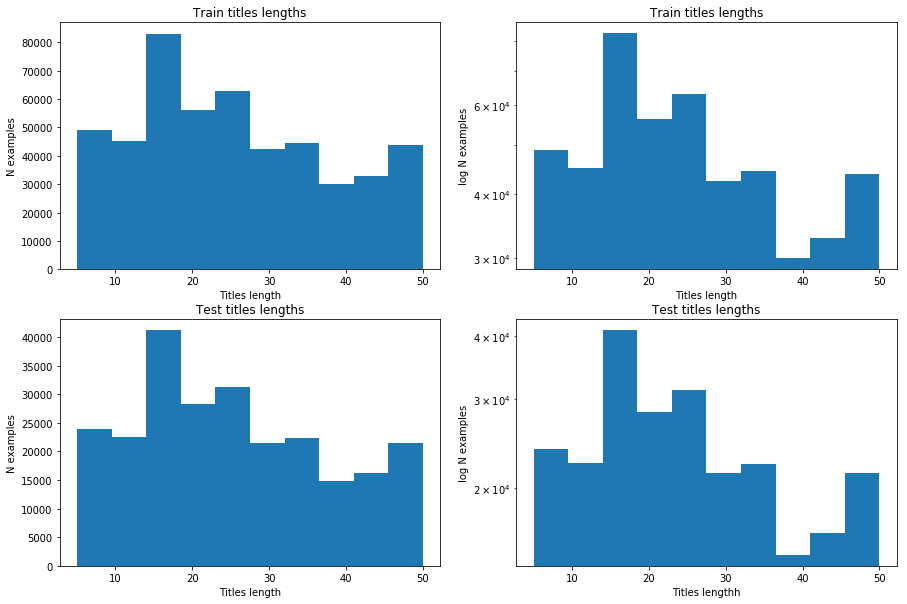

In [29]:
train_title_n_words = [len(title) for title in train_df['title'].tolist()]
test_title_n_words = [len(title) for title in test_df['title'].tolist()]

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0][0].hist(train_title_n_words)
set_pict_info(ax[0][0], 'Titles length', 'N examples', 'Train titles lengths')
ax[0][1].hist(train_title_n_words, log=True)
set_pict_info(ax[0][1], 'Titles length', 'log N examples', 'Train titles lengths')
ax[1][0].hist(test_title_n_words)
set_pict_info(ax[1][0], 'Titles length', 'N examples', 'Test titles lengths')
ax[1][1].hist(test_title_n_words, log=True)
set_pict_info(ax[1][1], 'Titles lengthh', 'log N examples', 'Test titles lengths')
fig.show()

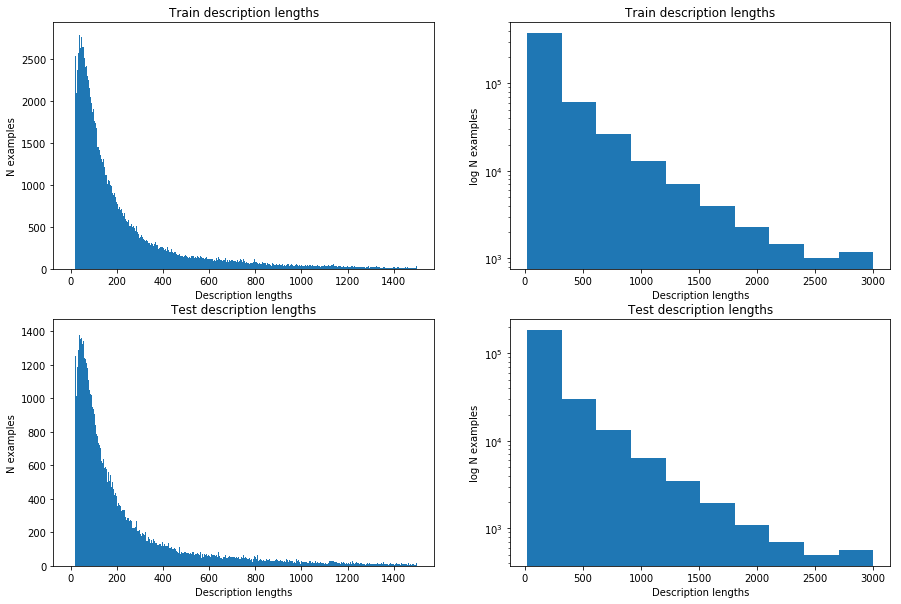

In [33]:
train_desc_n_words = [len(descr) for descr in train_df['description'].tolist()]
test_desc_n_words = [len(descr) for descr in test_df['description'].tolist()]

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0][0].hist(train_desc_n_words, range(0, 1500))
set_pict_info(ax[0][0], 'Description lengths', 'N examples', 'Train description lengths')
ax[0][1].hist(train_desc_n_words, log=True)
set_pict_info(ax[0][1], 'Description lengths', 'log N examples', 'Train description lengths')
ax[1][0].hist(test_desc_n_words, range(0, 1500))
set_pict_info(ax[1][0], 'Description lengths', 'N examples', 'Test description lengths')
ax[1][1].hist(test_desc_n_words, log=True)
set_pict_info(ax[1][1], 'Description lengths', 'log N examples', 'Test description lengths')
fig.show()

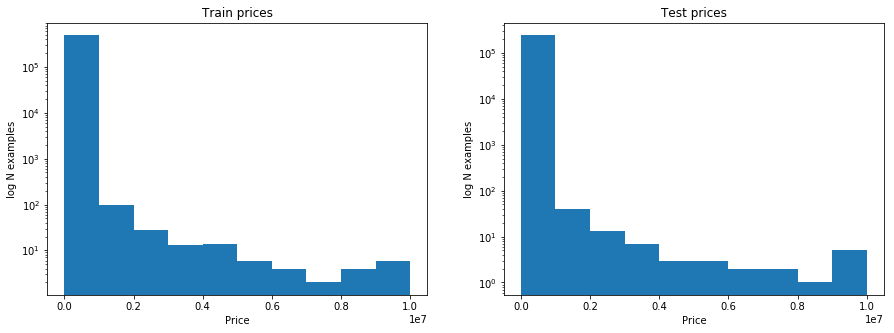

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(train_df['price'], log=True)
set_pict_info(ax[0], 'Price', 'log N examples', 'Train prices')
ax[1].hist(test_df['price'], log=True)
set_pict_info(ax[1], 'Price','log N examples', 'Test prices')
fig.show()

Data distribution is the same in all sets. Thanks to people who prepared data.

In [16]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

I thought it will be iteresting to see what words are the most frequent in texts.

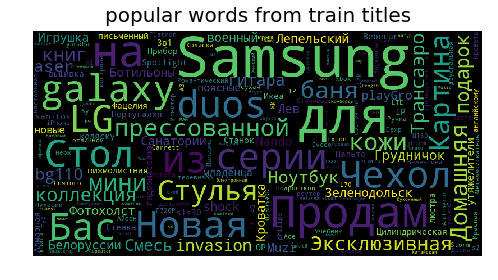

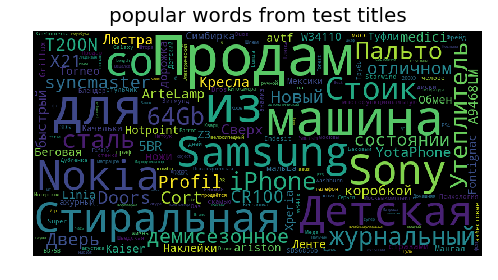

In [17]:
plot_wordcloud(train_df['title'], title="popular words from train titles", figure_size=(12, 4), title_size=20)
plot_wordcloud(test_df['title'], title="popular words from test titles", figure_size=(12, 4), title_size=20)

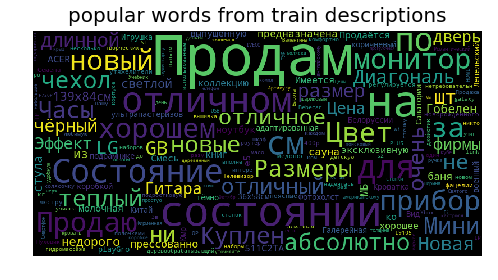

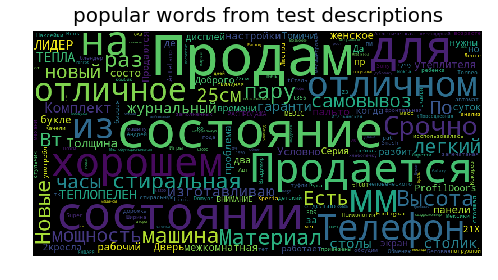

In [18]:
plot_wordcloud(train_df['description'], title="popular words from train descriptions", figure_size=(12, 4), title_size=20)
plot_wordcloud(test_df['description'], title="popular words from test descriptions", figure_size=(12, 4), title_size=20)

## Test functions

In [6]:
# function to get average accuracy
def get_accuracy(y_pred, y):
    true = np.sum(np.float32(y_pred == y))
    return true / len(y)

# function to get accuracy per each category
# category's ranges are in hierarchy_dict
def get_hierarchy_accuracy(y_pred, y, hierarchy_dict):
    acc_dict = {}
    for categ, range_ in hierarchy_dict.items():
        # find indeces where class is from current category
        indices = np.where(np.isin(y, range_) == True)[0]
        categ_true = np.sum(np.float32(y_pred[indices] == y[indices]))
        acc_dict[categ] = categ_true / len(indices)
    return acc_dict

## Process text

Descriptions and titles are joined to one text. Then this new text is tokenized with spacy lib. All tokens are concatenated with space. As price is integer I would mask it with # as I think that orders of magnitude matters more than exact number and append to descriptions and titles.

In [7]:
from spacy.lang.ru import Russian
nlp = Russian()

def prepare_text(title, description, price, nlp=Russian()):
    """
    This function tikenizes texts and return string in which all tokens
    are separated by space. This is because fasttext simply tokenize by
    splitting on spces.
    """
    # tokenize concatenated title and description and return string of concatenated tokens
    proc_text = ' '.join(token.string for token in nlp(title + ' ' + description))
    # mask price (i.e. 12000 -> price#####, 125 -> price###)
    enc_price = 'price' + re.sub('\d', '#', str(int(price)))
    proc_text = proc_text + ' ' + enc_price
    # remove multiple spaces
    proc_text = re.sub('\s{2,}', ' ', proc_text)
    return proc_text

2019-04-29 15:45:42,183 INFO: Loading dictionaries from /home/egor/DL/venvs/base/lib/python3.6/site-packages/pymorphy2_dicts/data
2019-04-29 15:45:42,229 INFO: format: 2.4, revision: 393442, updated: 2015-01-17T16:03:56.586168


In [39]:
# if data were already processed, load it, else process and save
if isfile(join(data_path, 'proccessed_train.csv')) and isfile(join(data_path, 'proccessed_test.csv')):
    train_df = pd.read_csv(join(data_path, 'proccessed_train.csv'))
    test_df = pd.read_csv(join(data_path, 'proccessed_test.csv'))
else:
    train_df['proc_text'] = train_df.apply(lambda x: prepare_text(x['title'], x['description'], x['price']), axis=1)
    test_df['proc_text'] = test_df.apply(lambda x: prepare_text(x['title'], x['description'], x['price']), axis=1)

    train_df.to_csv(join(data_path, 'proccessed_train.csv'), index=False)
    test_df.to_csv(join(data_path, 'proccessed_test.csv'), index=False)
    
    train_df = pd.read_csv(join(data_path, 'proccessed_train.csv'))
    test_df = pd.read_csv(join(data_path, 'proccessed_test.csv'))

Now we can see distribution of tokens in text prepared for training.

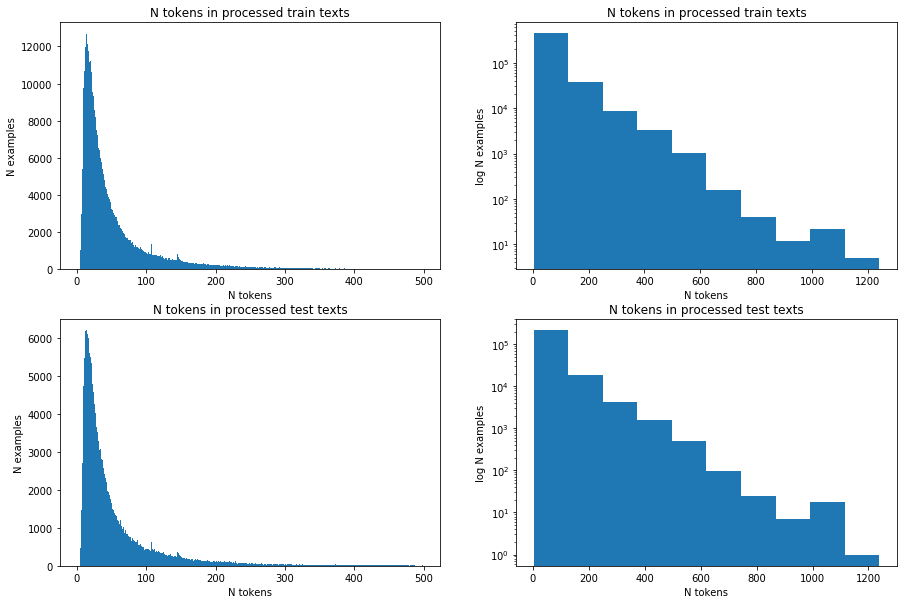

In [43]:
train_n_tokens = [len(text.split(' ')) for text in train_df['proc_text'].tolist()]
test_n_tokens = [len(text.split(' ')) for text in test_df['proc_text'].tolist()]

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0][0].hist(train_n_tokens, range(0, 500))
set_pict_info(ax[0][0], 'N tokens', 'N examples', 'N tokens in processed train texts')
ax[0][1].hist(train_n_tokens, log=True)
set_pict_info(ax[0][1], 'N tokens', 'log N examples', 'N tokens in processed train texts')
ax[1][0].hist(test_n_tokens, range(0, 500))
set_pict_info(ax[1][0], 'N tokens', 'N examples', 'N tokens in processed test texts')
ax[1][1].hist(test_n_tokens, log=True)
set_pict_info(ax[1][1], 'N tokens', 'log N examples', 'N tokens in processed test texts')
fig.show()

### Split on train and validation sets

In [9]:
# we have only train and test csvs. So train will be splitted on train and validation parts
train, val = train_test_split(train_df, test_size=0.15, stratify=train_df['category_id'], random_state=21)

## Models

### Fasttext

Firstly, I want to try fasttext model (https://fasttext.cc/) from facebook. It's fast and gives good results.

In [17]:
train_df.head()

,item_id,title,description,price,category_id,proc_text
0,0,Картина,Гобелен. Размеры 139х84см.,1000.0,19,Картина Гобелен . Размеры 139х84 см . price####
1,1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,22,Стулья из прессованной кожи Продам недорого 4 ...
2,2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,37,Домашняя мини баня Мини баня МБ-1(мини сауна )...
3,3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,43,"Эксклюзивная коллекция книг "" Трансаэро "" + по..."
4,4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,1,Ноутбук aser Продаётся ноутбук ACER e5 - 511C2...


In [21]:
# fasttext uses text files
# each line should contain one example
# at the beginning of line there should be __label__ word followed by label without space (__label__{actual label})
# if it is test data no __label__ in line
def make_fasttext_txt(df, path, test=False):
    with open(path, 'w') as f:
        for i in tqdm(range(len(df))):
            if not test:
                line = '__label__{} {} \n'.format(df.iloc[i]['category_id'], df.iloc[i]['proc_text'])
            else:
                line = '{} \n'.format(df.iloc[i]['proc_text'])
            f.write(line)

In [91]:
make_fasttext_txt(train, join(data_path, 'fasttext_train.txt'))
make_fasttext_txt(val, join(data_path, 'fasttext_val.txt'))
make_fasttext_txt(test_df, join(data_path, 'fasttext_test.txt', test=True))

In [105]:
# loading data created for fasttext
train_path = join(data_path, 'fasttext_train.txt')
val_path = join(data_path, 'fasttext_val.txt')
test_path = join(data_path, 'fasttext_test.txt')
model_path = '/home/egor/DL/AvitoTestTask/models_data/fasttext'

In [106]:
# changing dir to be able to call fasttext with ./fasttext (want to write less letters)
chdir('/home/egor/DL/fastText-0.2.0/')

In [184]:
# this parameters were found after several attempt
# hs loss - hierarchical softmax. I thought it will be useful as we have 53 labels (a lot)
# minCount - the least number of word apperance to add this word in vocabulary
# lr - learning rate with which we start
# epoch - N of epochs
!./fasttext supervised -lr 0.4 -epoch 5 -loss hs -minCount 5 -input $train_path -output $model_path

Read 24M words
Number of words:  149662
Number of labels: 54
Progress: 100.0% words/sec/thread: 2720738 lr:  0.000000 loss:  0.681247 ETA:   0h 0m


In [195]:
# N - nuber of iterations over data (use bathces, so N is less than number of examples)
# P@1 - precision
# R@1 - recall
!./fasttext test '/home/egor/DL/AvitoTestTask/models_data/fasttext.bin' $val_path

N	73428
P@1	0.85
R@1	0.85


Descriptions and titles will be joined to one text. As price is integer I would mask it with # as I think that orders of magnitude matters more than exact number and append to descriptions and titles.

In [249]:
# predict on val_data
pred = !./fasttext predict '/home/egor/DL/AvitoTestTask/models_data/fasttext.bin' $val_path
# result has format '__label__50' so
pred = np.array([i[9:] for i in pred], dtype=np.int)
y = np.array(val['category_id'], dtype=np.int)

In [268]:
# average accuracy
get_accuracy(pred, y)

0.8500027237566051

In [269]:
# accuracies per category
get_hierarchy_accuracy(pred, y, hierarchy_dict)

{'Бытовая_электроника': 0.8982285163189686,
 'Для дома и дачи': 0.8300119474313022,
 'Личные вещи': 0.8380863622242932,
 'Хобби и отдых': 0.8296522415753875}

In [271]:
# predict on test data
test_pred = !./fasttext predict '/home/egor/DL/AvitoTestTask/models_data/fasttext.bin' $test_path
test_pred = np.array([i[9:] for i in test_pred], dtype=np.int)

In [286]:
# make DataFrame with test predictions and save it
submission_dict = {'item_id': test_df['item_id'], 'category_id': test_pred}
submission_df = pd.DataFrame(submission_dict)
submission_df.to_csv(join(result_path, 'fasttext_test_prediction.csv'), index=False)
submission_df.head()

,item_id,category_id
0,489517,22
1,489518,0
2,489519,15
3,489520,33
4,489521,13


## ELMO + CNN

Now I want to use ELMO for feature extraction from texts. These featurese I will pass through 1dCNN and maxpool over filters.

ELMO implementation with weights for Russian language were taken from (https://github.com/HIT-SCIR/ELMoForManyLangs).

#### Dataset class

In [10]:
# dataset class
class AvitoDataset(Dataset):
    
    def __init__(self, df, text_col, label_col, sort_by_len=False):
        if sort_by_len:
            self.df = df.reindex(df[text_col].str.len().sort_values())
        else:
            self.df = df
        self.text_col = text_col
        self.label_col = label_col
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        x = self.df.iloc[index][self.text_col].split(' ')
        y = torch.tensor(self.df.iloc[index][self.label_col], dtype=torch.int)
        return x, y

# texts have different lengths. I have to manually define function which will pad sentences 
# in batch to the length on the longest one or 150 tokens (some sentenses are too long so batch
# won't fit into gpu memory)
# ELMO implementation I use takes list of string, so in batches xes are lists
def custom_collate(batch, maxlen=150):
    x = [i[0][:maxlen] for i in batch]
    y = [i[1] for i in batch]
    
    batch_maxlen = max([len(i) for i in x])
    
    padded_x = [i + [''] * (batch_maxlen - len(i)) for i in x]
    y = torch.LongTensor(y)
    return padded_x, y

In [12]:
# make sure dataset works as wanted
train_dataset = AvitoDataset(train_df, 'proc_text', 'category_id', sort_by_len=False)

In [13]:
for i in range(3):
    print(train_dataset[i])

(['Картина', 'Гобелен', '.', 'Размеры', '139х84', 'см', '.', 'price####'], tensor(19, dtype=torch.int32))
(['Стулья', 'из', 'прессованной', 'кожи', 'Продам', 'недорого', '4', 'стула', 'из', 'светлой', 'прессованной', 'кожи', ',', 'стильные', ',', 'ножки', 'дугообразные', '.', 'price####'], tensor(22, dtype=torch.int32))
(['Домашняя', 'мини', 'баня', 'Мини', 'баня', 'МБ-1(мини', 'сауна', ')', ',', 'предназначена', 'для', 'принятия', 'тепловых', 'процедур', 'в', 'бытовых', 'условиях(дома', ',', 'на', 'даче', ')', ',', 'а', 'также', 'в', 'спортивных', ',', 'оздоровительных', ',', 'косметических', ',', 'лечебных', 'организациях', 'и', 'учреждениях', '.', 'Она', 'оказывает', 'общеукрепляющее', 'и', 'профилактическое', 'действие', 'на', 'организм', 'человека', '.', 'Номинальное', 'напряжение', 'переменного', 'тока', '220', 'В', 'Максимальная', 'мощность', '2000', 'Вт', 'Максимальная', 'температура', 'нагретого', 'воздуха', 'в', 'термочехле', '(', 'градусов', 'С', ')', '90', '–', '100', 'Врем

In [14]:
# check custom collate function
loader = DataLoader(train_dataset, 3, collate_fn=custom_collate)

In [15]:
# sentences in batch are padded well
for x, y in loader:
    print(y)
    print(x)
    break

tensor([19, 22, 37])
[['Картина', 'Гобелен', '.', 'Размеры', '139х84', 'см', '.', 'price####', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], ['Стулья', 'из', 'прессованной', 'кожи', 'Продам', 'недорого', '4', 'стула', 'из', 'светлой', 'прессованной', 'кожи', ',', 'стильные', ',', 'ножки', 'дугообразные', '.', 'price####', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

In [11]:
elmo_weights = '/home/egor/DL/AvitoTestTask/data/ru_elmo'

Model architecture is:
- first, embeddings for each word are made by elmo
- second, three different 1d convolutions extract features from embeddings (different kernel sizes so each conv looks for different N-grams)
- third, conovlution activations are maxpooled and concatenated
- forth, fully connected layer makes logits

In [12]:
class ELMOCNNClassifier(Module):
    
    def __init__(self, n_classes, elmo_model_path, elmo_batch_size, kernel_sizes, 
                 n_filters, drop_rate=0.5):
        super().__init__()
        self.n_filters = n_filters
        
        self.elmo = Embedder(elmo_model_path, elmo_batch_size)
        self.conv0 = Conv1d(1024, n_filters, kernel_sizes[0])
        self.conv1 = Conv1d(1024, n_filters, kernel_sizes[1])        
        self.conv2 = Conv1d(1024, n_filters, kernel_sizes[2])
        self.dropout = Dropout(drop_rate)
        self.fc = Linear(3 * n_filters, n_classes)
        
    def conv_block(self, inputs, conv):
        conv_out = F.leaky_relu(conv(inputs.permute(0,2,1)))
        max_pooled = F.max_pool1d(conv_out, self.n_filters)
        return max_pooled
    
    # elmo returns list of embeddings. Here I concat them to batch and load batch to gpu
    def elmolist2tensor(self, elmo_out):
        tensors = [torch.tensor(sent, dtype=torch.float32).unsqueeze(0) for sent in elmo_out]
        batch = torch.cat(tensors, dim=0)
        return batch.cuda()
    
    # don't use softmax on the last layer because it's more numerically stable
    # to use CrossEntropyLoss which has softmax inside
    def forward(self, inputs):
        
        elmo_out = self.elmo.sents2elmo(inputs)
        elmo_out = self.elmolist2tensor(elmo_out)
        
        max_out0 = self.conv_block(elmo_out, self.conv0)
        max_out1 = self.conv_block(elmo_out, self.conv1)   
        max_out2 = self.conv_block(elmo_out, self.conv2)
        
        max_out = torch.cat([max_out0, max_out1, max_out2], dim=1).squeeze(2)
        
        logits = self.fc(self.dropout(max_out))
        
        return logits

In [38]:
# test model implementation
n_classes = categ_df['category_id'].nunique()

model = ELMOCNNClassifier(n_classes, elmo_weights, 32, [1,3,5], 200)
criterion = CrossEntropyLoss()

In [39]:
# test model implementation
for x, y in loader:
    print(len(x[0]))
    pred = model(x)
    print(pred.shape)
    loss = criterion(pred, y)
    print(loss)
    break

NameError: name 'loader' is not defined

In [13]:
# function to calculate accuracy when training
def accuracy(y_pred, y):
    pred_lbl = y_pred.argmax(dim=1)
    correct = (pred_lbl == y).float()
    acc = torch.mean(correct.sum(dim=0) / correct.shape[0])
    return acc

In [14]:
def train_model(model, loader, criterion, optimizer):
    model.cuda()
    model.train()
    
    epoch_loss, epoch_acc = 0., 0.
    
    for x, y in tqdm(loader):
        y = y.cuda()
        
        model.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        acc = accuracy(pred, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

def evaluate_model(model, loader, criterion):
    model.cuda()
    model.eval()
    
    epoch_loss, epoch_acc = 0., 0.
    
    with torch.no_grad():
        for x, y in tqdm(loader):
            y = y.cuda()
            
            pred = model(x)
            loss = criterion(pred, y)
            acc = accuracy(pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [15]:
def save_model(model, optimizer, name):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'model_decription': str(model)
    }, name)
    
def update_history(history, train_loss, train_acc, val_loss, val_acc):
    if 'train_loss' not in history:
        history['train_loss'] = []
    if 'train_acc' not in history:
        history['train_acc'] = []
    if 'val_loss' not in history:
        history['val_loss'] = []
    if 'val_acc' not in history:
        history['val_acc'] = []
        
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)    
    history['val_loss'].append(val_loss)    
    history['val_acc'].append(val_acc) 
    return history

### Training

In [16]:
# make everything needed for training
elmo_weights = '/home/egor/DL/AvitoTestTask/data/ru_elmo'
bs = 32
n_classes = categ_df['category_id'].nunique()
kernel_sizes = [1, 3, 5]
n_filters = 1024
drop_rate = 0.2
epochs = 10

train_dataset = AvitoDataset(train, text_col='proc_text', label_col='category_id')
val_dataset = AvitoDataset(val, text_col='proc_text', label_col='category_id')
train_loader = DataLoader(train_dataset, bs, collate_fn=custom_collate, num_workers=4)
val_loader = DataLoader(val_dataset, bs, collate_fn=custom_collate, num_workers=4)

# use this because ELMO implementatiom from https://github.com/HIT-SCIR/ELMoForManyLangs 
# doesn't get device as a parameter
torch.cuda.set_device(1)

In [19]:
# first tqdm_notebook were used in train_model and evaluate_model
# but I realized that output of tqdm_notebooks brokes after restarting jupyter
# so it was replaced with tqdm
# as training was reeeealy long I didn't rerun it for beautiful output (I am sorry)
model = ELMOCNNClassifier(n_classes=n_classes, elmo_model_path=elmo_weights, elmo_batch_size=bs,
                         kernel_sizes=kernel_sizes, n_filters=n_filters, drop_rate=drop_rate)
optimizer = torch.optim.Adam(model.parameters())
criterion = CrossEntropyLoss()

history = {}
best_loss = np.inf

for epoch in range(epochs):
    
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate_model(model, val_loader, criterion)
    
    if val_loss < best_loss:
        best_loss = val_loss
        save_model(model, optimizer, join('models_data', 'elmocnn.ptr'))
        
    history = update_history(history, train_loss, train_acc, val_loss, val_acc)
    
    print('{} | TRAIN loss: {:.4f}, acc: {:.4f}; VAL loss: {:.4f}, acc: {:.4f}'.
             format(epoch + 1, train_loss, train_acc, val_loss, val_acc))


1 | TRAIN loss: 0.8223, acc: 0.7761; VAL loss: 0.6918, acc: 0.8134



2 | TRAIN loss: 0.6987, acc: 0.8123; VAL loss: 0.6890, acc: 0.8169



3 | TRAIN loss: 0.6640, acc: 0.8245; VAL loss: 0.6995, acc: 0.8207


KeyboardInterrupt: 

Long learning (~3 hours for an epoch) and not really great results comparing to fasttext.

In [17]:
saved_model_info = torch.load(join('models_data', 'elmocnn.ptr'))
saved_model_info.keys()

dict_keys(['model_state_dict', 'optimizer_state_dict', 'model_decription'])

In [18]:
# loading model
model = ELMOCNNClassifier(n_classes=n_classes, elmo_model_path=elmo_weights, elmo_batch_size=bs,
                         kernel_sizes=kernel_sizes, n_filters=n_filters, drop_rate=drop_rate)
model.load_state_dict(saved_model_info['model_state_dict'])

### Calculate accuracies on validation data

In [25]:
model.cuda()
model.eval()

val_preds, val_labels = [], []

for x, y in tqdm(val_loader):
    pred = model(x)
    categ_ids = pred.argmax(dim=1).tolist()
    
    val_preds.append(categ_ids)
    val_labels.append(y.tolist())

100%|██████████| 2295/2295 [24:44<00:00,  1.69it/s]


In [39]:
# I made a mistake and insted of += used append, so here error is corrected
val_preds = [p for batch_preds in val_preds for p in batch_preds]
val_labels = [l for batch_lbls in val_labels for l in batch_lbls]

In [44]:
# average accuracy
get_accuracy(np.array(val_preds), np.array(val_labels))

0.8206951026856241

In [45]:
# average accuracy per category
get_hierarchy_accuracy(np.array(val_preds), np.array(val_labels), hierarchy_dict)

{'Бытовая_электроника': 0.9108674686564133,
 'Для дома и дачи': 0.808984468339307,
 'Личные вещи': 0.7578751164958062,
 'Хобби и отдых': 0.7895492907164662}

### Predict on test data

In [19]:
# for test data I can't use previous dataset class as there is no labels
class TestDataset(Dataset):
    
    def __init__(self, df, id_col, text_col):
        self.df = df
        self.id_col = id_col
        self.text_col = text_col
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        item_id = self.df.iloc[index][self.id_col]
        tokens = self.df.iloc[index][self.text_col].split(' ')
        return tokens, item_id

def custom_test_collate(batch, maxlen=150):
    x = [i[0][:maxlen] for i in batch]
    item_ids = [i[1] for i in batch]
    
    batch_maxlen = max([len(i) for i in x])
    
    padded_x = [i + [''] * (batch_maxlen - len(i)) for i in x]
    return padded_x, item_ids

In [20]:
# turn eval mode to disable dropouts and put model to gpu
# here we don't see elmo in model because it's weights are not parameters
model.eval()
model.cuda()

ELMOCNNClassifier(
  (conv0): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
  (conv1): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(1024, 1024, kernel_size=(5,), stride=(1,))
  (dropout): Dropout(p=0.2)
  (fc): Linear(in_features=3072, out_features=54, bias=True)
)

In [21]:
# dict to collect predictions
submission_dict = {
    'item_id': [],
    'category_id': [],
}

test_dataset = TestDataset(test_df, id_col='item_id', text_col='proc_text')
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=custom_test_collate, shuffle=False)

for tokens, item_id in tqdm(test_loader):
    pred = model(tokens)
    categ_ids = pred.argmax(dim=1).tolist()
    submission_dict['item_id'] += item_id
    submission_dict['category_id'] += categ_ids

100%|██████████| 7599/7599 [1:22:26<00:00,  1.59it/s]


In [22]:
# make DataFrame with test predictions and save it
submission_df = pd.DataFrame(submission_dict)
submission_df.to_csv(join(result_path, 'elmocnn_test_prediction.csv'), index=False)
submission_df.head()

,item_id,category_id
0,489517,22
1,489518,0
2,489519,15
3,489520,33
4,489521,13
